In [1]:
# %load base.py
# 기본 패키지 불러오기
import numpy as np
import pandas as pd
import warnings
import mglearn
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
%matplotlib inline

# jtplot style 설정
jtplot.style(theme='gruvboxd', grid=False)

# matplotlib 한글 폰트 설정
plt.rcParams['font.family'] = 'NanumGothic'

# -부호 깨지지 않게 하기
plt.rcParams['axes.unicode_minus'] = False

# 경고 무시
warnings.filterwarnings("ignore")

C:\Users\Administrator\.conda\envs\multicampus\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
C:\Users\Administrator\.conda\envs\multicampus\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)
scaler = MinMaxScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)

svm = SVC()
svm.fit(X_train_scaled, y_train)
X_test_scaled = scaler.transform(X_test)
print('테스트 점수: {:.2f}'.format(svm.score(X_test_scaled, y_test)))

테스트 점수: 0.95


# 데이터 전처리와 매개변수 선택

In [3]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
             'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=5)
grid.fit(X_train_scaled, y_train)
print('최상의 교차 검증 정확도: {:.2f}'.format(grid.best_score_))
print('테스트 점수: {:.2f}'.format(grid.score(X_test_scaled, y_test)))
print('최적의 매개변수:', grid.best_params_)

최상의 교차 검증 정확도: 0.98
테스트 점수: 0.97
최적의 매개변수: {'C': 1, 'gamma': 1}


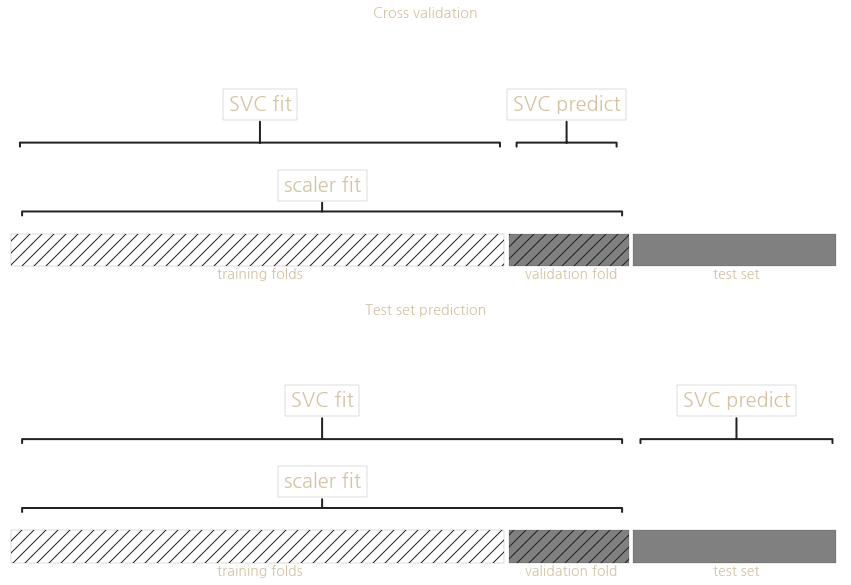

In [4]:
mglearn.plots.plot_improper_processing()

# 파이프라인 구축하기

In [5]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([('scaler', MinMaxScaler()), ('svm', SVC())])

In [6]:
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('svm',
                 SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3,
                     gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

In [7]:
print('테스트 점수: {:.2f}'.format(pipe.score(X_test, y_test)))

테스트 점수: 0.95


# 그리드 서치에 파이프라인 적용하기

In [8]:
param_grid = {'svm__C': [0.001, 0.01, 0.1, 1, 10, 100],
             'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

In [9]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)
print('최상의 교차 검증 정확도: {:.2f}'.format(grid.best_score_))
print('테스트 세트 점수: {:.2f}'.format(grid.score(X_test, y_test)))
print('최적의 매개변수:', grid.best_params_)

최상의 교차 검증 정확도: 0.98
테스트 세트 점수: 0.97
최적의 매개변수: {'svm__C': 1, 'svm__gamma': 1}


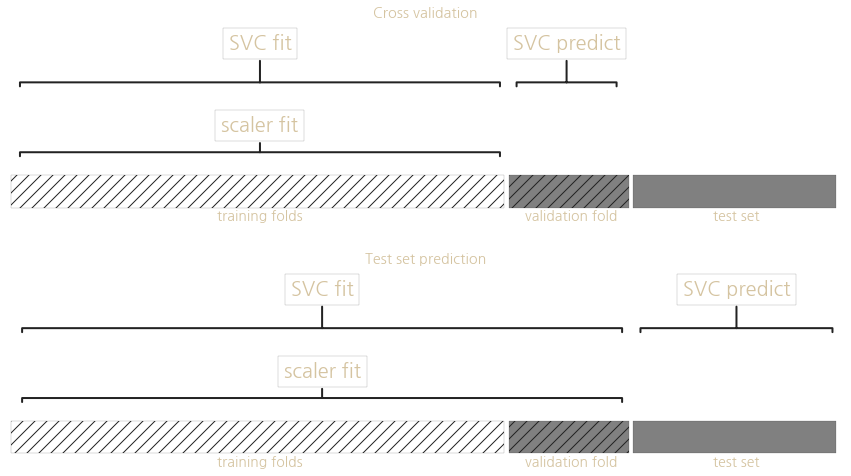

In [10]:
mglearn.plots.plot_proper_processing()

## 정보 누설에 대한 예시

In [11]:
rnd = np.random.RandomState(seed=0)
X = rnd.normal(size=(100, 10000))
y = rnd.normal(size=(100,))

In [12]:
from sklearn.feature_selection import SelectPercentile, f_regression

select = SelectPercentile(score_func=f_regression, percentile=5).fit(X, y)
X_selected = select.transform(X)
print('X_selected.shape:', X_selected.shape)

X_selected.shape: (100, 500)


In [13]:
# 정보 누설로 인해 점수가 높게 나왔다.
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
print('교차 검증 점수(리지): {:.2f}'.format(np.mean(cross_val_score(Ridge(), X_selected, y, cv=5))))

교차 검증 점수(리지): 0.91


In [14]:
# 정보 누설이 되지 않아 점수가 낮게 나온다.
pipe = Pipeline([('select', SelectPercentile(score_func=f_regression, percentile=5)),
                ('ridge', Ridge())])
print('교차 검증 점수(파이프라인): {:.2f}'.format(np.mean(cross_val_score(pipe, X, y, cv=5))))

교차 검증 점수(파이프라인): -0.25


# 파이프라인 인터페이스

In [15]:
def fit(self, X, y):
    X_transformed = X
    for name, estimator in self.steps[:-1]:
        X_transformed = estimator.fit_transform(X_transformed, y)
    self.steps[:-1][1].fit(X_transformed, y)
    return self

In [16]:
def predict(self, X):
    X_transformed = X
    for step in self.steps[:-1]:
        X_transformed = step[1].transform(X_transformed)
    return self.steps[-1][1].predict(X_transformed)

## make_pipeline을 사용한 파이프라인 생성

In [17]:
from sklearn.pipeline import make_pipeline
pipe_long = Pipeline([('scaler', MinMaxScaler()), ('svm', SVC(C=100))])
pipe_short = make_pipeline(MinMaxScaler(), SVC(C=100))

In [18]:
print('파이프라인 단계:\n', pipe_short.steps)

파이프라인 단계:
 [('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('svc', SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False))]


In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pipe = make_pipeline(StandardScaler(), PCA(n_components=2), StandardScaler())
print('파이프라인 단계:\n', pipe.steps)

파이프라인 단계:
 [('standardscaler-1', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)), ('standardscaler-2', StandardScaler(copy=True, with_mean=True, with_std=True))]


## 단계 속성에 접근하기

In [20]:
pipe.fit(cancer.data)
components = pipe.named_steps['pca'].components_
print('components.shape', components.shape)

components.shape (2, 30)


## 그리드 서치 안의 파이프라인 속성에 접근하기

In [21]:
from sklearn.linear_model import LogisticRegression
pipe = make_pipeline(StandardScaler(), LogisticRegression())

In [22]:
param_grid = {'logisticregression__C': [0.01, 0.1, 1, 10, 100]}

In [23]:
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=4)
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('logisticregression',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=100,
                                                     

In [24]:
print('최상의 모델:\n', grid.best_estimator_)

최상의 모델:
 Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logisticregression',
                 LogisticRegression(C=0.1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='warn', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)


In [25]:
print('로지스틱 회귀 단계:\n', grid.best_estimator_.named_steps['logisticregression'])

로지스틱 회귀 단계:
 LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


In [26]:
print('로지스틱 회귀 계수:\n', grid.best_estimator_.named_steps['logisticregression'].coef_)

로지스틱 회귀 계수:
 [[-0.38856355 -0.37529972 -0.37624793 -0.39649439 -0.11519359  0.01709608
  -0.3550729  -0.38995414 -0.05780518  0.20879795 -0.49487753 -0.0036321
  -0.37122718 -0.38337777 -0.04488715  0.19752816  0.00424822 -0.04857196
   0.21023226  0.22444999 -0.54669761 -0.52542026 -0.49881157 -0.51451071
  -0.39256847 -0.12293451 -0.38827425 -0.4169485  -0.32533663 -0.13926972]]


# 전처리와 모델의 매개변수를 위한 그리드 서치

In [27]:
from sklearn.datasets import load_boston
from sklearn.preprocessing import PolynomialFeatures

boston = load_boston()
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target, random_state=0)
pipe = make_pipeline(StandardScaler(), PolynomialFeatures(), Ridge())

In [30]:
param_grid = {'polynomialfeatures__degree': [1,2,3],
             'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

In [31]:
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('polynomialfeatures',
                                        PolynomialFeatures(degree=2,
                                                           include_bias=True,
                                                           interaction_only=False,
                                                           order='C')),
                                       ('ridge',
                                        Ridge(alpha=1.0, copy_X=True,
                                              fit_intercept=True, max_iter=None,
                                              normalize=False,
         

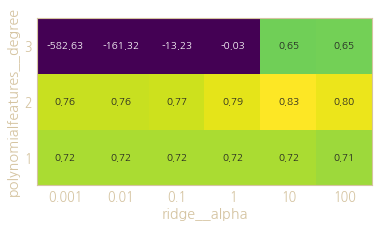

In [32]:
mglearn.tools.heatmap(grid.cv_results_['mean_test_score'].reshape(3, -1),
                     xlabel='ridge__alpha', ylabel='polynomialfeatures__degree',
                     xticklabels=param_grid['ridge__alpha'],
                     yticklabels=param_grid['polynomialfeatures__degree'], vmin=0)

In [33]:
print('최적의 매개변수:', grid.best_params_)

최적의 매개변수: {'polynomialfeatures__degree': 2, 'ridge__alpha': 10}


In [34]:
print('테스트 세트 점수: {:.2f}'.format(grid.score(X_test, y_test)))

테스트 세트 점수: 0.77


In [35]:
param_grid = {'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
pipe = make_pipeline(StandardScaler(), Ridge())
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
print('다항 특성이 없을 때 점수: {:.2f}'.format(grid.score(X_test, y_test)))

다항 특성이 없을 때 점수: 0.63


# 모델 선택을 위한 그리드 서치

In [36]:
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC())])

In [37]:
from sklearn.ensemble import RandomForestClassifier

param_grid = [
    {'classifier': [SVC()], 'preprocessing': [StandardScaler()],
    'classifier__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]},
    {'classifier': [RandomForestClassifier(n_estimators=100)],
    'preprocessing': [None], 'classifier__max_features': [1,2,3]}
]

In [38]:
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

print('최적의 매개변수:\n{}\n'.format(grid.best_params_))
print('최상의 교차 검증 점수: {:.2f}'.format(grid.best_score_))
print('테스트 세트 점수: {:.2f}'.format(grid.score(X_test, y_test)))

최적의 매개변수:
{'classifier': SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False), 'classifier__C': 10, 'classifier__gamma': 0.01, 'preprocessing': StandardScaler(copy=True, with_mean=True, with_std=True)}

최상의 교차 검증 점수: 0.99
테스트 세트 점수: 0.98


## 중복 계산 피하기
계산 비용이 높은 그리드 서치 실행 시 dask-ml 라이브러리를 찾아보자.

In [40]:
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC())], memory='cache_folder')